<a href="https://colab.research.google.com/github/AmbikaRahulSingh/Distracted-Driver-MultiAction-Classification/blob/main/Project_4_Distracted_Driver_MultiAction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing required libraries

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dropout,Input,Dense,GlobalAveragePooling2D
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping, Callback

from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.preprocessing import image 

from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [2]:
!wget https://www.dropbox.com/s/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip

--2021-05-20 08:31:13--  https://www.dropbox.com/s/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip [following]
--2021-05-20 08:31:13--  https://www.dropbox.com/s/raw/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc81b96a006045163713b555a348.dl.dropboxusercontent.com/cd/0/inline/BO38G5MCDbPPx6ReXuUH8IwRjMiYm_wMDbmPyUt9p_b609g3-1_e5VAetqF0GLnNE1s2aVxZWfSNEQr3Tk-juK57Dqhu5mAMWQEnv84jsESsL-N_DIiTmZzBp5UbgNkEl1HZ04AwxJ4hYdp1iX5N2HB5/file# [following]
--2021-05-20 08:31:14--  https://uc81b96a006045163713b555a348.dl.dropboxusercontent.com/cd/0/inline/

In [3]:
# Unzipping data to extract contents
!unzip state-farm-distracted-driver-detection.zip
!unzip imgs.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/c7/img_56661.jpg  
  inflating: train/c7/img_56699.jpg  
  inflating: train/c7/img_56717.jpg  
  inflating: train/c7/img_56724.jpg  
  inflating: train/c7/img_56768.jpg  
  inflating: train/c7/img_56779.jpg  
  inflating: train/c7/img_56849.jpg  
  inflating: train/c7/img_56899.jpg  
  inflating: train/c7/img_56938.jpg  
  inflating: train/c7/img_5706.jpg   
  inflating: train/c7/img_57076.jpg  
  inflating: train/c7/img_57122.jpg  
  inflating: train/c7/img_57137.jpg  
  inflating: train/c7/img_5715.jpg   
  inflating: train/c7/img_57278.jpg  
  inflating: train/c7/img_57321.jpg  
  inflating: train/c7/img_57345.jpg  
  inflating: train/c7/img_57355.jpg  
  inflating: train/c7/img_5741.jpg   
  inflating: train/c7/img_57433.jpg  
  inflating: train/c7/img_5753.jpg   
  inflating: train/c7/img_57559.jpg  
  inflating: train/c7/img_57594.jpg  
  inflating: train/c7/img_5771.jpg   
  inflating: train/c7/img_57712.jpg  

In [4]:
# Removing unwanted folders
!rm -rf __MACOSX
!rm state-farm-distracted-driver-detection.zip
!rm imgs.zip

In [5]:
# Naming the train path and test paths
Train_Images_Path = "/content/train"

Test_Images_Path =  "/content/test"

imgs_list_file = pd.read_csv("/content/driver_imgs_list.csv")

# Note: Train folder has sub folders like c0,c1 etc., where as test folder has images directly with no folders- need to consider while extracting images from folders

In [6]:
imgs_list_file

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [7]:
imgs_list_file=imgs_list_file.loc[:,['classname','img']]
imgs_list_file

,classname,img
0,c0,img_44733.jpg
1,c0,img_72999.jpg
2,c0,img_25094.jpg
3,c0,img_69092.jpg
4,c0,img_92629.jpg
...,...,...
22419,c9,img_56936.jpg
22420,c9,img_46218.jpg
22421,c9,img_25946.jpg
22422,c9,img_67850.jpg


In [8]:
data_classes = imgs_list_file.groupby(by='classname').count().reset_index()
data_classes

,classname,img
0,c0,2489
1,c1,2267
2,c2,2317
3,c3,2346
4,c4,2326
5,c5,2312
6,c6,2325
7,c7,2002
8,c8,1911
9,c9,2129


In [9]:
data_x = list(pd.unique(imgs_list_file['classname']))
print (data_x)
data_y =list(data_classes['img'])
print (data_y)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
[2489, 2267, 2317, 2346, 2326, 2312, 2325, 2002, 1911, 2129]


In [10]:
# Extracting images and labels from the train folder
# Note: Train folder has sub folders like c0,c1 etc., where as test folder has images directly with no folders- need to consider while extracting images from folders

imgs_train = []
labels_train = []

for dir in sorted(glob.glob(os.path.join(Train_Images_Path, '*')), key = lambda k: k.split("/")[-1]):
# The above code takes you to path "/content/train/c4" for eg - now split by / and then -1 position gives c4 in this case
  for imgs in glob.glob(os.path.join(dir,'*.jpg')):
# The above code will take you to path '/content/train/c4/img_78402.jpg' for eg- 
# now split by / and then -1 position gives img_78402.jpg in this case
      train_img_cv2 = cv2.imread(imgs)
      # This method reads the color image from the path specified.
      train_img_cv2 = cv2.resize(train_img_cv2,(128,128))
      # Let us resize the images to 128*128
      imgs_train.append(train_img_cv2)
      labels_train.append(int(dir.split("/")[-1].replace('c','')))
      # The above line will take u to path '/content/train/c4' for eg - now split by / and then -1 position gives c4 in this case
      # Then replacing c with "" returns int 4. 


In [11]:
len(imgs_train)

22424

In [12]:
len(labels_train)

22424

In [14]:
# splitting the data into train and test datasets
    
X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgs_train,labels_train, test_size = 0.2)

Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
# The above code will give you Y_Train as 10 dimensional vector 
Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

In [15]:
Y_Train.shape

(17939, 10)

In [16]:
X_Train=np.array(X_Train)

In [17]:
X_Train.shape

(17939, 128, 128, 3)

In [18]:
X_Test=np.array(X_Test)
X_Test.shape

(4485, 128, 128, 3)

In [19]:
Y_Test.shape

(4485, 10)

In [20]:
cv2.imread('/content/train/c4/img_78402.jpg', cv2.IMREAD_UNCHANGED).shape

(480, 640, 3)

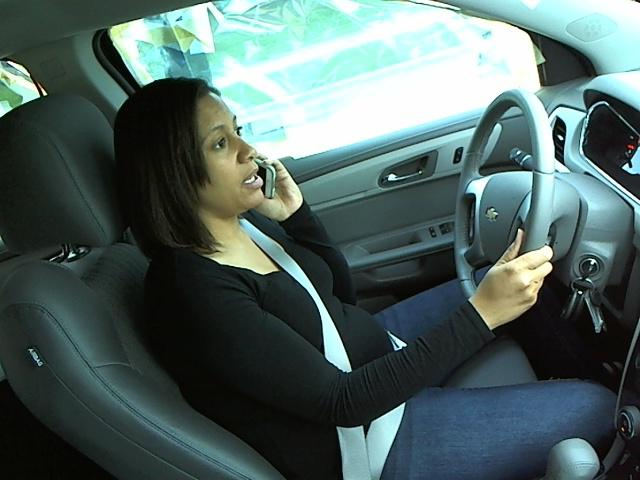

In [13]:
from google.colab.patches import cv2_imshow

import cv2

cv2_imshow(cv2.imread('/content/train/c4/img_78402.jpg', cv2.IMREAD_UNCHANGED))


In [22]:
print(len(X_Train),len(Y_Train))
print(len(X_Test),len(Y_Test))

17939 17939
4485 4485


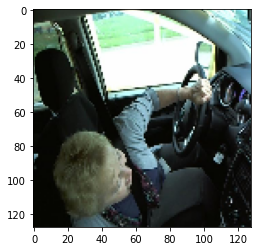

Class: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [23]:
# Example to see if the preprocessing was done correctly:
img = X_Train[1601]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print("Class: {}".format(Y_Train[1601]))

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

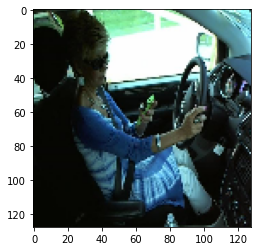

Class: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [24]:
# Example to see if the preprocessing was done correctly:
img = X_Train[1611]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print("Class: {}".format(Y_Train[1611]))

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

In [ ]:
## Creating model architecture using keras sequential API

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=(128, 128, 3)))

model.add(keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides = (1,1),padding='same',activation='relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(filters = 64,kernel_size = (5,5),strides = (1,1),padding = 'same',activation = 'relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(filters = 128,kernel_size = (5,5),strides = (1,1),padding = 'same',activation = 'relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Conv2D(filters = 256,kernel_size = (5,5),strides = (1,1),padding = 'same',activation = 'relu'))

model.add(keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=1024, activation='relu'))

model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Dense(units=512, activation='relu'))

model.add(keras.layers.Dense(units=10,activation='softmax'))

model.summary()

plot_model(model)

tf.random.set_seed(2)

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])

history = model.fit(x = X_Train, y=Y_Train, epochs = 5, batch_size = 500, verbose = 1,validation_split=0.2)

test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

# Saving the model 

from tensorflow.keras.models import model_from_json

model_json = model.to_json()

with open("model.json", "w") as json_file:

    json_file.write(model_json)

model.save_weights('model_weights.h5',overwrite = True)


In [15]:
# loading the model 

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')

loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.summary()

loaded_model.load_weights('model_weights.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 256)      

In [16]:
Test_img_cv2 = cv2.imread("/content/test/img_99018.jpg")
Test_img_cv2 = cv2.resize(Test_img_cv2,(128,128))
Test_img_cv2 = np.reshape(Test_img_cv2,[1,128,128,3])
predict_result = loaded_model.predict(Test_img_cv2,batch_size = 1)
print(predict_result)

[[1.1130004e-05 9.9757749e-01 4.3315886e-06 2.0595668e-04 5.8321559e-05
  1.9353900e-05 6.5196631e-04 1.0654131e-06 1.2979358e-04 1.3405889e-03]]


In [17]:
Test_img_cv2.shape

(1, 128, 128, 3)

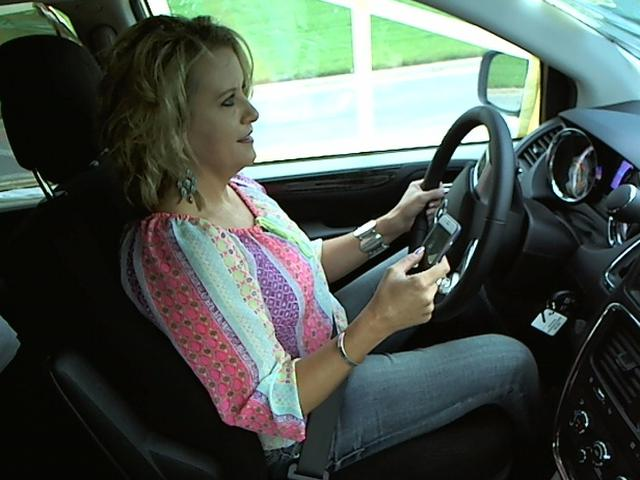

0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [18]:
from google.colab.patches import cv2_imshow

import cv2

cv2_imshow(cv2.imread('/content/test/img_99018.jpg', cv2.IMREAD_UNCHANGED))

print(round(predict_result[0][0],2))
print(round(predict_result[0][1],2))
print(round(predict_result[0][2],2))
print(round(predict_result[0][3],2))
print(round(predict_result[0][4],2))
print(round(predict_result[0][5],2))
print(round(predict_result[0][6],2))
print(round(predict_result[0][7],2))
print(round(predict_result[0][8],2))
print(round(predict_result[0][9],2))

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

In [19]:
#  create a submission file for predictions and defining a function for predictions:

submission = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})

def predict_test(Test_Images_Path,submission):
    for imgs in glob.glob(os.path.join(Test_Images_Path,'*.jpg')):
    # The above code will take you to path '/content/test/img_78402.jpg' for eg
        Test_img_cv2 = cv2.imread(imgs)
        Test_img_cv2 = cv2.resize(Test_img_cv2,(128,128))
        Test_img_cv2 = np.reshape(Test_img_cv2,[1,128,128,3])
        predict_result = loaded_model.predict(Test_img_cv2,batch_size = 1)
        #print(imgs.split('/')[-1])
        submission = submission.append(
            {
                'img':imgs.split('/')[-1], 'c0':round(predict_result[0][0],2), 'c1':round(predict_result[0][1],2), 'c2':round(predict_result[0][2],2), 'c3':round(predict_result[0][3],2), 'c4':round(predict_result[0][4],2), 
                'c5':round(predict_result[0][5],2), 'c6':round(predict_result[0][6],2), 'c7':round(predict_result[0][7],2), 'c8':round(predict_result[0][8],2), 'c9':round(predict_result[0][9],2)
            },
            ignore_index=True
        )
    return submission
# imgs.split('/')[-1] will return eg: img_78402.jpg for '/content/test/img_78402.jpg'

In [20]:
submission = predict_test(Test_Images_Path,submission)

In [21]:
print(submission.shape)
submission.head(5)

(79726, 11)


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_27638.jpg,0.00,0.00,0.39,0.00,0.00,0.0,0.06,0.55,0.00,0.00
1,img_62187.jpg,0.00,0.00,0.00,0.00,0.59,0.0,0.40,0.00,0.00,0.00
2,img_4956.jpg,0.13,0.01,0.00,0.02,0.02,0.0,0.00,0.01,0.78,0.03
3,img_49348.jpg,0.12,0.00,0.00,0.00,0.00,0.0,0.00,0.09,0.13,0.66
4,img_66237.jpg,0.00,0.00,0.13,0.00,0.00,0.0,0.00,0.00,0.87,0.00


In [22]:
submission.to_csv('Ambika_Tupakula_P4.csv',index = False)

In [23]:
submission.tail(5)

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
79721,img_15847.jpg,0.00,0.1,0.00,0.00,0.00,0.00,0.27,0.48,0.14,0.00
79722,img_67579.jpg,0.13,0.0,0.06,0.48,0.00,0.00,0.02,0.00,0.10,0.21
79723,img_79413.jpg,0.16,0.0,0.04,0.00,0.00,0.02,0.01,0.00,0.65,0.12
79724,img_38937.jpg,0.33,0.0,0.00,0.00,0.62,0.00,0.05,0.00,0.00,0.00
79725,img_44318.jpg,0.00,0.0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


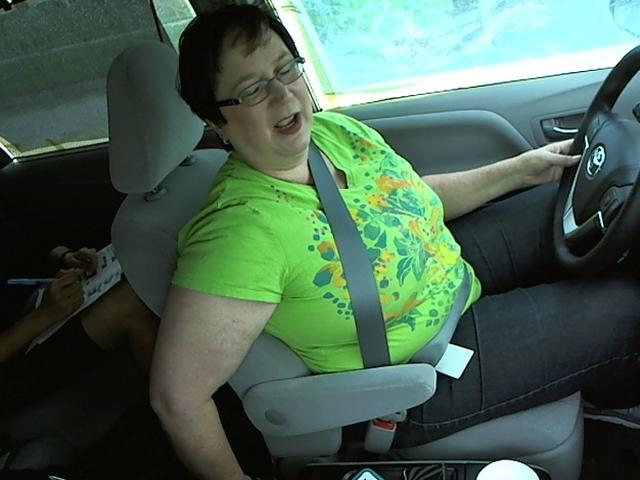

In [24]:
# Let us see our model performance on test data for the 5 records pulled from submission.tail(5)

cv2_imshow(cv2.imread('/content/test/img_15847.jpg', cv2.IMREAD_UNCHANGED))

# prediction was img_15847.jpg	0.00	0.1	0.00	0.00	0.00	0.00	0.27	0.48	0.14	0.00

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

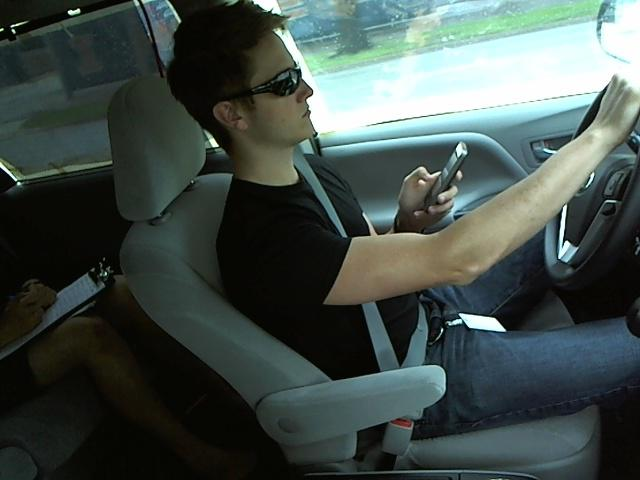

In [25]:
cv2_imshow(cv2.imread('/content/test/img_67579.jpg', cv2.IMREAD_UNCHANGED))

# prediction was img_67579.jpg	0.13	0.0	0.06	0.48	0.00	0.00	0.02	0.00	0.10	0.21

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

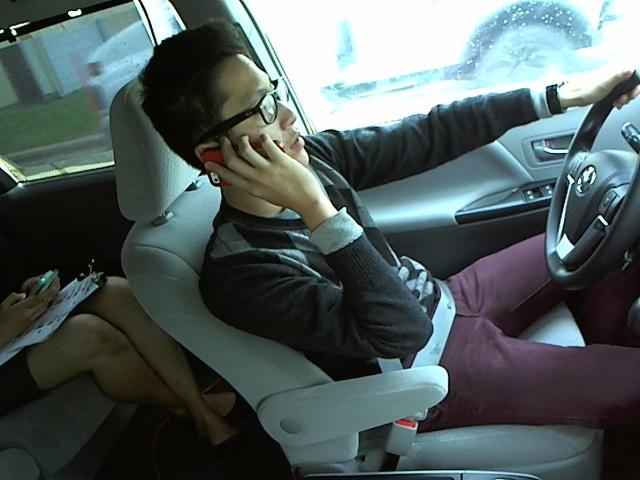

In [29]:
cv2_imshow(cv2.imread('/content/test/img_79413.jpg', cv2.IMREAD_UNCHANGED))

# prediction was img_79413.jpg	0.16	0.0	0.04	0.00	0.00	0.02	0.01	0.00	0.65	0.12

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

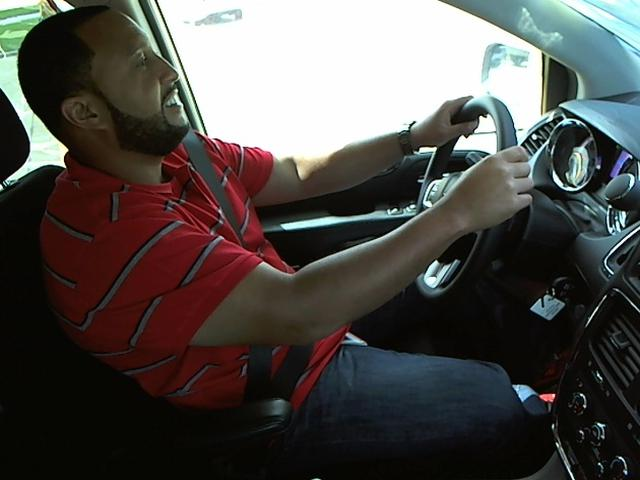

In [27]:
cv2_imshow(cv2.imread('/content/test/img_38937.jpg', cv2.IMREAD_UNCHANGED))

# prediction was img_38937.jpg	0.33	0.0	0.00	0.00	0.62	0.00	0.05	0.00	0.00	0.00

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;

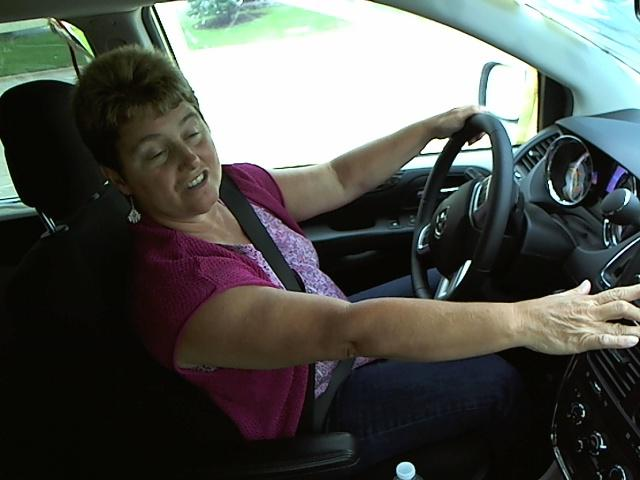

In [28]:
cv2_imshow(cv2.imread('/content/test/img_44318.jpg', cv2.IMREAD_UNCHANGED))

# prediction was img_44318.jpg	0.00	0.0	0.00	0.00	0.00	1.00	0.00	0.00	0.00	0.00

# c0: safe driving; c1: texting - right; c2: talking on the phone - right; c3: texting - left;

# c4: talking on the phone - left; c5: operating the radio; c6: drinking; c7: reaching behind;

# c8: hair and makeup; c9: talking to passenger;